In [12]:
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorboard.backend.event_processing import event_accumulator
import numpy as np
import seaborn as sns
import pandas as pd
from brokenaxes import brokenaxes
import sys
import os
import math

sys.path.append('..')
sys.path.append('../interlacer')
sys.path.append('..')
sys.path.append('../scripts')
import matplotlib.pyplot as plt
import interlacer.utils as utils
import interlacer.layers as layers
import interlacer.models as models
import scripts.training_config as training_config
import interlacer.data_generator as data_generator
import interlacer.fastmri_data_generator as fastmri_data_generator
import interlacer.losses as losses
import scripts.filepaths as filepaths
import visualization_lib
import warnings
font_size=32

plt.rcParams.update({'font.size': 40})
plt.rcParams.update({'font.sans-serif':'Arial'})
plt.rcParams.update({'font.family':'sans-serif'})
%matplotlib inline

In [14]:
exp_str = 'knee_losssweep_fs' #knee_losssweep for non fat-saturated
base_dir = os.path.join(filepaths.TRAIN_DIR,exp_str) 
exps = os.listdir(base_dir)
exps = [i for i in exps if '.png' not in i]

In [15]:
def get_loss_label(l_t):
    if(l_t=='image'):
        return 'Image L1'
    elif(l_t=='freq'):
        return 'Freq L1'
    elif(l_t=='joint'):
        return 'Joint L1'
    elif(l_t=='ssim'):
        return '1-SSIM'
    elif(l_t=='ssim_ms'):
        return '1-Multiscale SSIM'
    elif(l_t=='psnr'):
        return '40-PSNR'

In [16]:
losses_list = ['Image L1','Freq L1','Joint L1','1-SSIM','1-Multiscale SSIM','40-PSNR']

In [17]:
n = 320
base_dir = filepaths.TRAIN_DIR

def get_model_metrics(exp_name,exp_str,run_name,m_input,m_output):
    exp_dir = base_dir+exp_name  
    config_path = base_dir + exp_name + '/' + run_name + '/' + run_name+'_config.ini'
    model_path = base_dir + exp_name + '/' + run_name
    exp_config = training_config.TrainingConfig(config_path)
    exp_config.read_config()
    
    exp_config, model = visualization_lib.load_model(config_path)
    best_epoch = visualization_lib.get_best_ckpt(model_path)
    ckptname = 'cp-'+str(best_epoch).zfill(4)+'.ckpt'

    used_loss = losses.image_loss(exp_config.output_domain,exp_config.loss) 
    image_l1 = losses.image_loss(exp_config.output_domain,'L1')
    fourier_l1 = losses.fourier_loss(exp_config.output_domain,'L1')
    joint_l1 = losses.joint_img_freq_loss(exp_config.output_domain,'L1', 0.1)

    ssim = losses.ssim(exp_config.output_domain)
    ssim_ms = losses.ssim_multiscale(exp_config.output_domain)
    lpips = losses.lpips(exp_config.output_domain)
    psnr = losses.psnr(exp_config.output_domain)

    model.compile(optimizer=keras.optimizers.Adam(),
        loss=used_loss,
        metrics=[image_l1, fourier_l1, joint_l1, ssim, ssim_ms, lpips, psnr])
    model.load_weights(os.path.join(model_path,ckptname))

    if(exp_config.output_domain=='IMAGE'):
        m_input = utils.convert_tensor_to_image_domain(m_input)
        m_output = utils.convert_tensor_to_image_domain(m_output)
    
    maes = []
    for i in range(96):
        m_input_i = tf.expand_dims(m_input[i,:,:,:],0)
        m_output_i = tf.expand_dims(m_output[i,:,:,:],0)
        maes.append(model.evaluate(m_input_i,m_output_i,verbose=0)[1:])
        
    return maes   

In [18]:

fastmri_dir = filepaths.FASTMRI_DATA_DIR
test_slice_dir = os.path.join(fastmri_dir, 'validate/singlecoil_val')
val_generator = fastmri_data_generator.generate_data(test_slice_dir, 'undersample', 'FREQ', 'FREQ', 0.75, batch_size=96)
m_input,m_output = next(val_generator)

cols = ['architecture','loss']
cols.extend(losses_list)
results = pd.DataFrame(columns = cols)

for exp in exps:
    exp_dir = os.path.join(base_dir,'knee_losssweep',exp)
    config_path = os.path.join(exp_dir,exp+'_config.ini')

    exp_config = training_config.TrainingConfig(config_path)
    exp_config.read_config()

    architecture = exp_config.architecture
    input_domain = exp_config.input_domain
    num_layer = exp_config.num_layers
    activation = exp_config.nonlinearity
    corruption_frac = exp_config.corruption_frac
    
    loss_type = exp_config.loss_type

    run_name = 'FASTMRI-undersample-'+str(corruption_frac)+'-'+architecture+'-9-32-'+str(num_layer)+'-'+loss_type+'-L1-0.1-'+input_domain+'-'+input_domain+'-'+activation+'-5000-8'
    
    if(exp_config.corruption_frac=='0.75'):
        m_input,m_output = m_input_4,m_output_4
    
    metrics = get_model_metrics('knee_losssweep','undersample',run_name,m_input,m_output)  
    
    architecture = exp_config.architecture[:-9]
    if('CONV' in architecture): 
        architecture = exp_config.input_domain
    if('INTERLACER' in architecture):
        architecture = 'JOINT'
    loss = get_loss_label(exp_config.loss_type)
    
    for i in range(96):
        m_i = metrics[i]
        metrics_df = pd.DataFrame({'architecture':architecture,'loss':loss,'Image L1':m_i[0],'Freq L1':m_i[1],'Joint L1':m_i[2],'1-SSIM':1+m_i[3],'1-Multiscale SSIM':1+m_i[4],'LPIPS':m_i[5],'40-PSNR':40+m_i[6]},index=[i])
        results = results.append(metrics_df,ignore_index=True)

results.to_csv('summary_data_cvpr_comp_img/'+exp_str+'_val.csv')
        


In [22]:
for df in [results]:
    df.replace(to_replace='ALTERNATING', value='Alternating', inplace=True, limit=None, regex=False, method='pad')
    df.replace(to_replace='JOINT', value='Interleaved', inplace=True, limit=None, regex=False, method='pad')
    df.replace(to_replace='IMAGE', value='Image', inplace=True, limit=None, regex=False, method='pad')
    df.replace(to_replace='FREQ', value='Frequency', inplace=True, limit=None, regex=False, method='pad')

In [31]:
df.replace(to_replace='1-Multiscale SSIM', value='1-SSIM-ms', inplace=True, limit=None, regex=False, method='pad')
losses_list = ['Image L1','Freq L1','Joint L1','1-SSIM','1-SSIM-ms','40-PSNR']
df['1-SSIM-ms']=df['1-Multiscale SSIM']

Text(0.0, 0.5, 'Evaluation Metric')

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


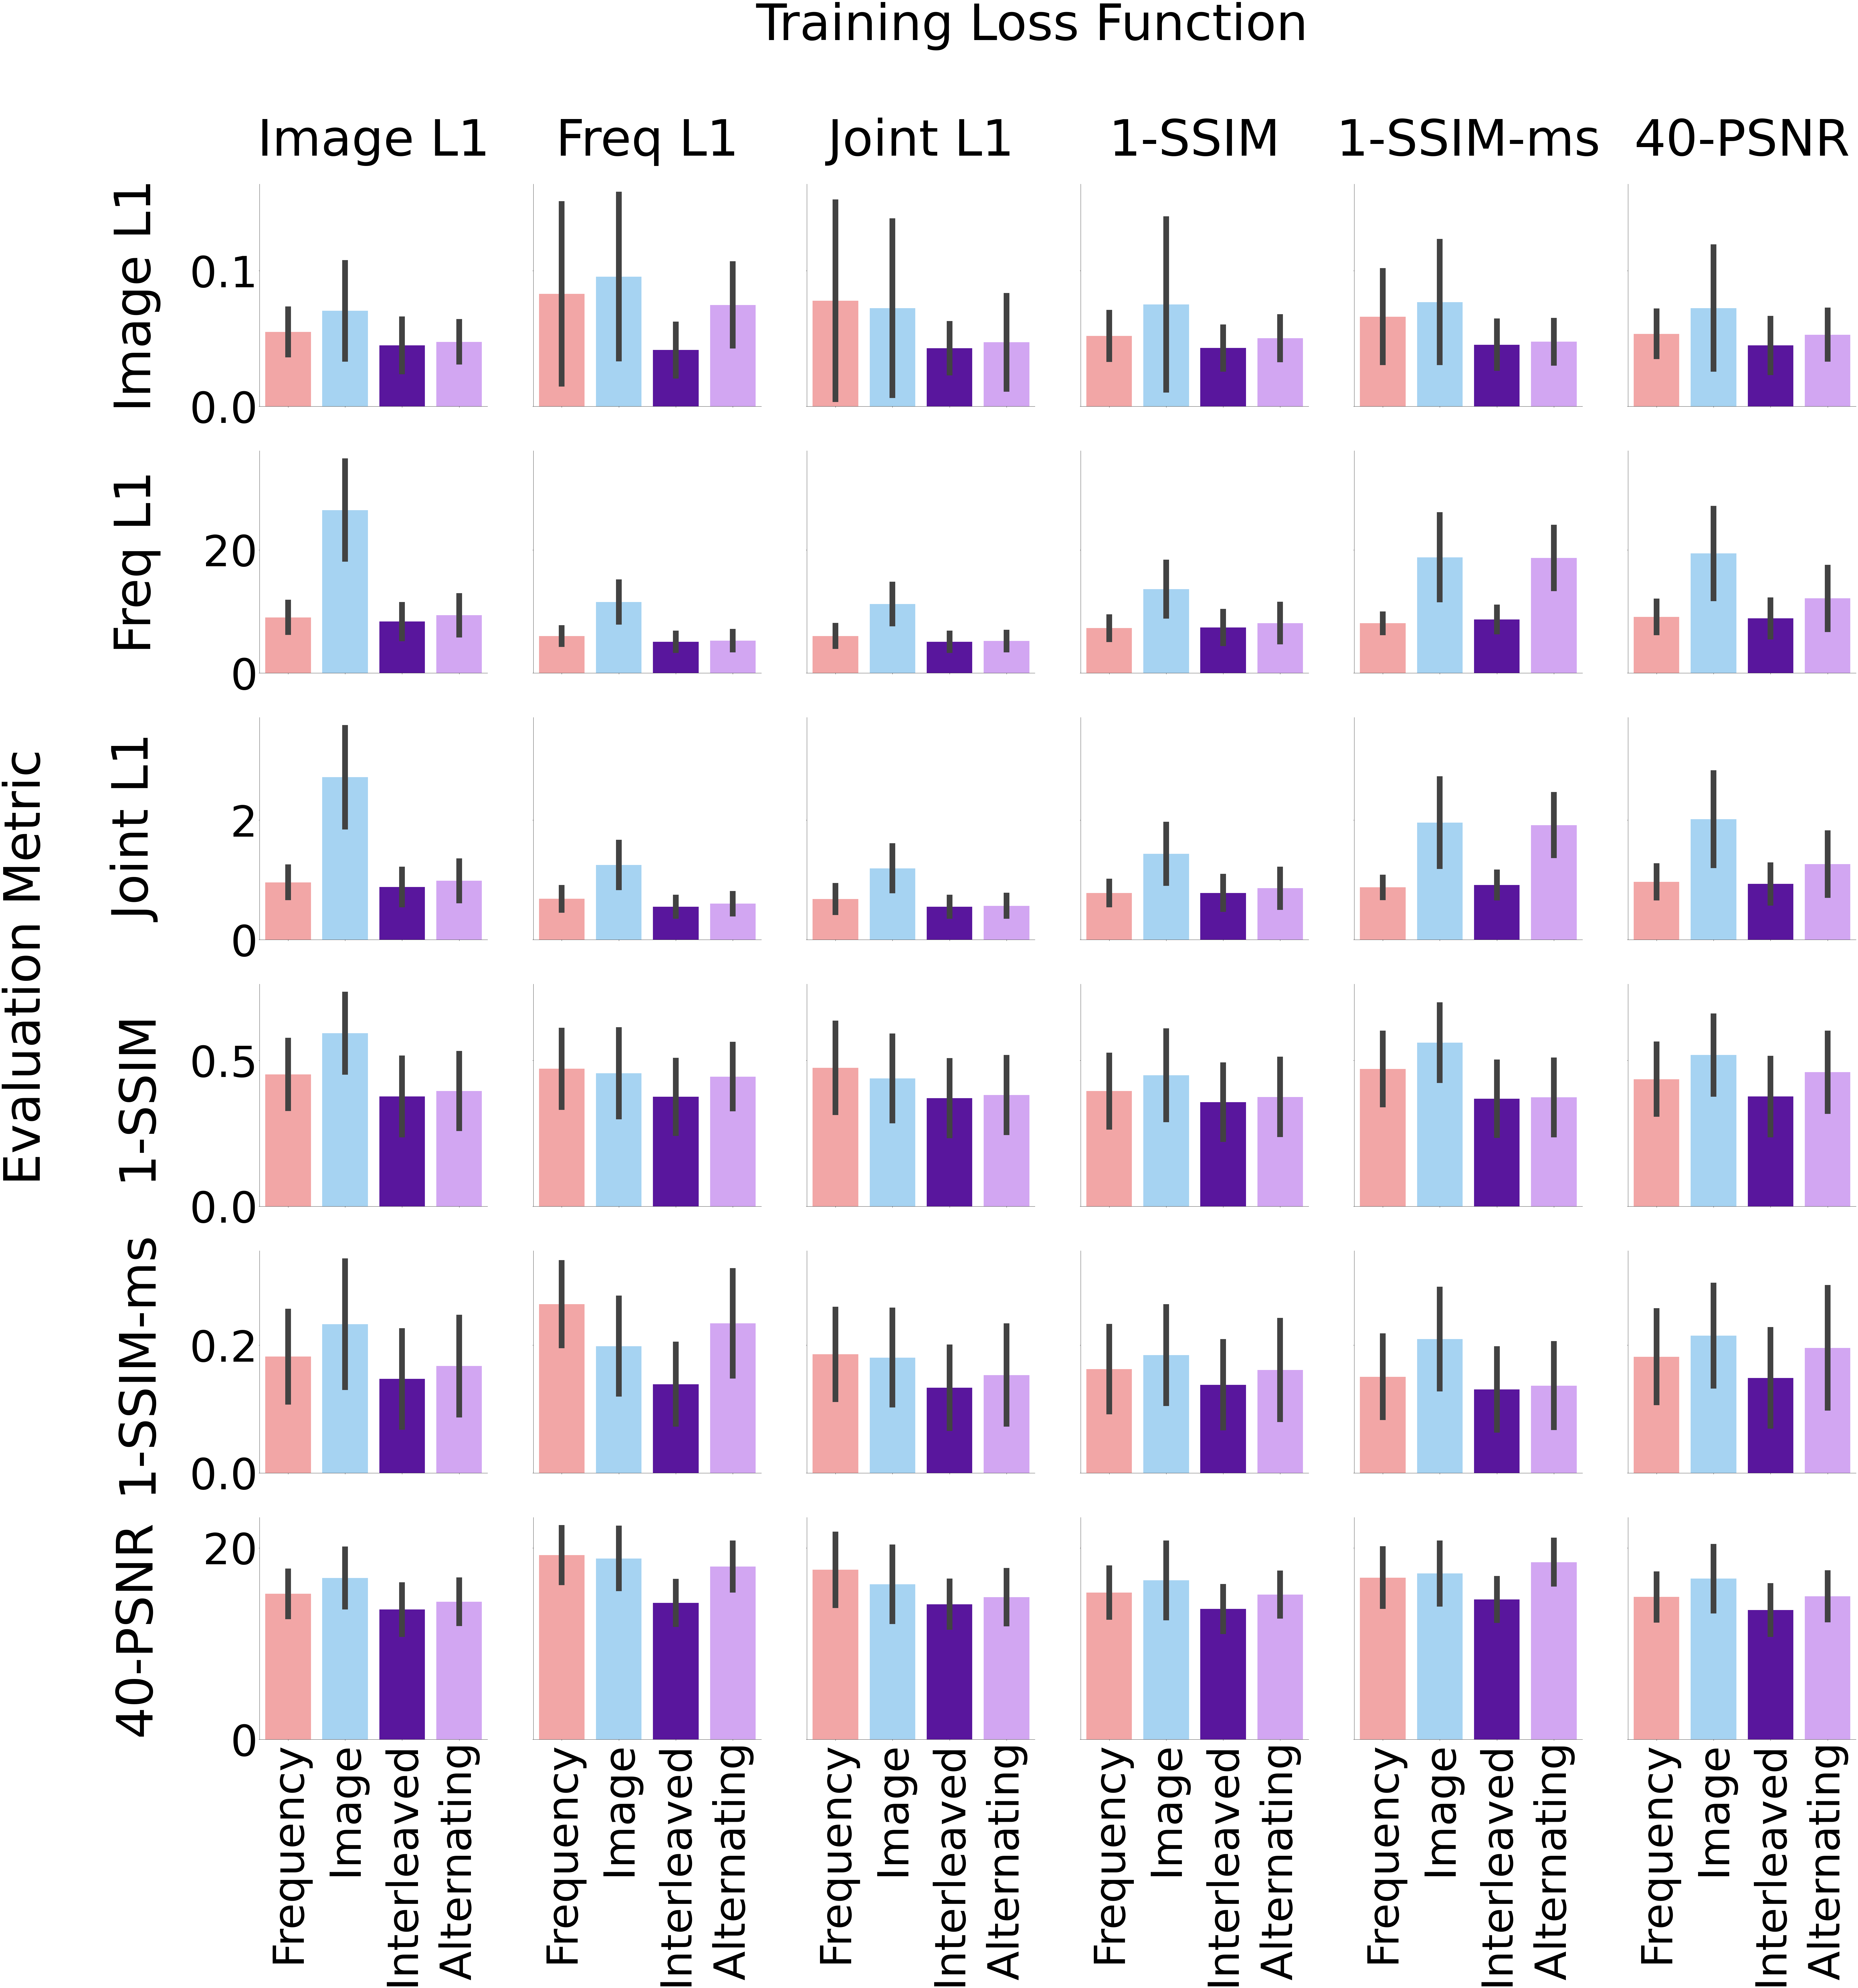

In [32]:
plt.rcParams.update({'font.size': 175})

f, axes = plt.subplots(6, 6, figsize=(100,100),sharey='row',sharex='col')
hue_order = ['Frequency','Image','Interleaved','Alternating']
palette = ['#ff9999','#99d6ff','#5900b3','#d499ff']


for i in range(6):
    for j in range(6):
        sns.barplot('architecture',losses_list[i],data=results[results['loss']==losses_list[j]],ax=axes[i][j],order=hue_order, ci='sd', hue_order = hue_order, palette = palette, errwidth=20)
        
        ax = axes[i][j]
        # Hide the right and top spines
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        
        # Only show ticks on the left and bottom spines
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')
        
        
        ax.set_xlabel('')
        ax.set_ylabel('',labelpad=100)        

        
        if(i==0):
            ax.set_title(losses_list[j],size=175,pad=100)
        
        if(i!=5):
            for tk in ax.get_xticklabels():
                tk.set_visible(False)
        else:
            for tk in ax.get_xticklabels():
                tk.set_visible(True)
                tk.set_rotation(90)
                tk.set_size(150)
                
        if(j==0):
            ax.set_ylabel(losses_list[i])
            for tk in ax.get_yticklabels():
                tk.set_visible(True)
                tk.set_size(150)
        else:
            for tk in ax.get_yticklabels():
                tk.set_visible(False)
f.align_ylabels(axes[:, 0])


f.text(0.5, 0.95, 'Training Loss Function', ha='center')
f.text(0.0, 0.5, 'Evaluation Metric', va='center', rotation='vertical')

In [33]:
f.savefig(exp_str+'_plots.pdf')